In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import xesmf as xe
 
from mlprecip_utils import *
from mlprecip_datasets import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

### Set Variables for plotting, region, etc.

In [2]:
varname='precip'
model_types=['cnn_cat'] 

# Define SEUS Region
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

### Read ERA-Interim Precip Data

In [3]:
files='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.precip.*.nc'
ds=xr.open_mfdataset(files,combine='by_coords')
print(ds['time'].values)

['1979-01-01T12:00:00.000000000' '1979-01-02T00:00:00.000000000'
 '1979-01-03T00:00:00.000000000' ... '2019-08-29T00:00:00.000000000'
 '2019-08-30T00:00:00.000000000' '2019-08-31T00:00:00.000000000']


### Read Land file and maskout 

In [4]:
land_file='/shared/ccsm4/kpegion/obs2/NCEPR1/land.144x73.nc'
ds_land=xr.open_dataset(land_file).squeeze()
ds.coords['mask'] = (('lat', 'lon'), ds_land['land'].values)
ds=ds.where(ds['mask']==1)

### Anomalies

In [5]:
ds_anoms=ds['precip'].groupby('time.dayofyear')-daily_climo(ds['precip'],'precip')
ds_anoms

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 14854)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    mask       (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 236 237 238 239 240 241 242 243
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-08-31
Data variables:
    precip     (time, lat, lon) float64 dask.array<chunksize=(1, 73, 144), meta=np.ndarray>

## Read in Predictor Fields

#### Filenames

In [6]:
zfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.19*.nc'
zfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2000s.nc'
zfiles3='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2010s.nc'
zfiles4='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2019s.nc'

ufiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.19*.nc'
ufiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2000s.nc'
ufiles3='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2010s.nc'
ufiles4='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2019s.nc'

tfile1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
tfile2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.2019s.nc'

olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'

#### Z500 and Z850

In [7]:
ds_z1=xr.open_mfdataset(zfiles1,combine='by_coords').sel(level=slice(100,1000))
ds_z2=xr.open_dataset(zfiles2).sel(level=slice(100,1000))
ds_z3=xr.open_dataset(zfiles3).sel(level=slice(100,1000))
ds_z4=xr.open_dataset(zfiles4)
ds_z=xr.combine_by_coords([ds_z1,ds_z2,ds_z3,ds_z4])

ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

#### U200 and U850

In [8]:
ds_u1=xr.open_mfdataset(ufiles1,combine='by_coords').sel(level=slice(100,1000))
ds_u2=xr.open_dataset(ufiles2).sel(level=slice(100,1000))
ds_u3=xr.open_dataset(ufiles3).sel(level=slice(100,1000))
ds_u4=xr.open_dataset(ufiles4)
ds_u=xr.combine_by_coords([ds_u1,ds_u2,ds_u3,ds_u4],combine_attrs='override')

ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
ds_u850=ds_u.sel(level=850).rename({'u':'u850'})
ds_u250=ds_u.sel(level=250).rename({'u':'u250'})

In [9]:
ds_u850

<xarray.Dataset>
Dimensions:  (time: 14853, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
    level    float32 850.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    u850     (time, lat, lon) float32 dask.array<chunksize=(365, 73, 72), meta=np.ndarray>
Attributes:
    Conventions:  None
    source_file:  /homes/khuang8/obs/reanalysis/era-interim/ncformat//homes/k...
    title:        Daily mean Zonal Wind Component from Era-Interim

#### SST

In [10]:
ds_sst1=xr.open_dataset(tfile1)
ds_sst2=xr.open_dataset(tfile2)

In [11]:
ds_sst2=ds_sst2.sel(time=slice('2019-01-01','2019-09-01'))

In [12]:
ds_sst=xr.combine_by_coords([ds_sst1,ds_sst2],combine_attrs='override')

#### OLR

In [13]:
ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts')
ds_olr1['time']=ds_olr1['time'].dt.floor('d')
ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords')
ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})

In [14]:
ds_olr

<xarray.Dataset>
Dimensions:  (time: 14854, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    olr      (time, lat, lon) float32 dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

### Coarse Grain the Predictor Data

In [15]:
new_lon=np.arange(0,360,5)
new_lat=np.arange(-90,92,5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)})

regridder = xe.Regridder(ds_anoms,ds_out,'bilinear',periodic=True)
ds_anoms=regridder(ds_anoms)

regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
ds_z500=regridder(ds_z500.chunk({'lon':-1}))
ds_z850=regridder(ds_z850.chunk({'lon':-1}))
ds_u200=regridder(ds_u200.chunk({'lon':-1}))
ds_u250=regridder(ds_u250.chunk({'lon':-1}))
ds_u850=regridder(ds_u850.chunk({'lon':-1}))
ds_olr=regridder(ds_olr.chunk({'lon':-1}))

regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
ds_sst=regridder_sst(ds_sst).fillna(0.0)

In [16]:
ds_u850

<xarray.Dataset>
Dimensions:  (time: 14853, lat: 37, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
    level    float32 850.0
  * lon      (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat      (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
Data variables:
    u850     (time, lat, lon) float32 dask.array<chunksize=(365, 37, 72), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Put all predictors together and make anomalies

In [17]:
ds_features=xr.merge([ds_z500,ds_z850,ds_u200,ds_u850,ds_olr,ds_sst],compat='override')

for v in list(ds_features.keys()):
    climo=daily_climo(ds_features[v],v)[v]
    ds_features[v]=ds_features[v].groupby('time.dayofyear')-climo

### Mask out the SEUS region with zeros in Predictor Data

In [18]:
ds_mask_1=xr.where(np.logical_and(ds_features['lon']>lon_reg[0],ds_features['lon']<lon_reg[1]),1,0)
ds_mask_2=xr.where(np.logical_and(ds_features['lat']>lat_reg[0],ds_features['lat']<lat_reg[1]),1,0)
ds_features=xr.where(ds_mask_1+ds_mask_2==2,0,ds_features)
ds_features=(ds_features.transpose('time','lat','lon'))
ds_features

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 37, time: 59412)
Coordinates:
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * time       (time) datetime64[ns] 1979-01-01 ... 2019-08-31T18:00:00
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 ... 242 242 242 242 243 243 243 243
Data variables:
    z500       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    z850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u200       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    olr        (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    sst        (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>

### Maskout OLR poleward of 30 in predictor Data

In [19]:
ds_features['olr']=xr.where(np.abs(ds_features['lat'])>30,0,ds_features['olr'])

### Split Target and Predictor Data into Test and Train/Validate

In [20]:
# Features
ds_features_tval=ds_features.sel(time=slice('1979-01-01','2016-12-31'))
ds_features_test=ds_features.sel(time=slice('2017-01-01','2019-09-01'))

# Target
weights=np.cos(np.deg2rad(ds_anoms['lat']))
ds_anoms=ds_anoms*weights
ds_anoms_tval=ds_anoms.sel(time=slice('1979-01-01','2016-12-31'))
ds_target_tval=ds_anoms_tval.sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)
ds_anoms_test=ds_anoms.sel(time=slice('2017-01-01','2019-09-01'))
ds_target_test=ds_anoms_test.sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)


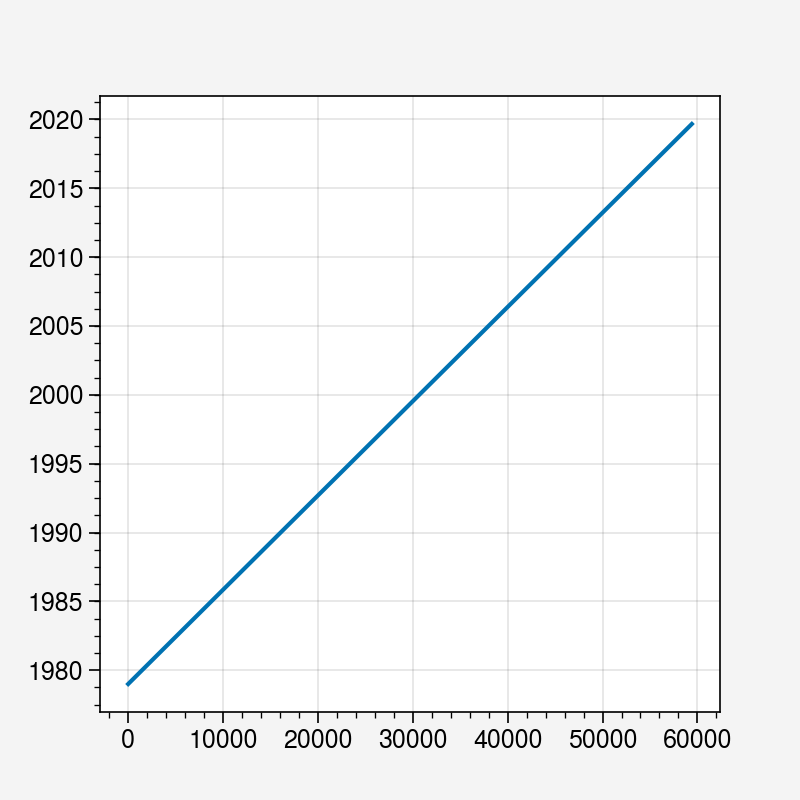

In [21]:
plt.plot(ds_features['time'])

In [22]:
ds_target_tval

<xarray.Dataset>
Dimensions:    (time: 13880)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2016-12-31
Data variables:
    precip     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [23]:
ds_features_tval

<xarray.Dataset>
Dimensions:    (time: 55520, lat: 37, lon: 72)
Coordinates:
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * time       (time) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 ... 365 365 365 365 366 366 366 366
Data variables:
    z500       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    z850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u200       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    olr        (lat, time, lon) float64 dask.array<chunksize=(37, 4, 72), meta=np.ndarray>
    sst        (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>

### Write out train and test data for CNN

In [28]:
# Write target to cnn
ds_target_tval.to_netcdf('../data/cnn/era-interim-precip/target_trainval.nc')
ds_target_test.to_netcdf('../data/cnn/era-interim-precip/target_test.nc')

# Write target to fnn
ds_target_tval.to_netcdf('../data/fnn/era-interim-precip/target_trainval.nc')
ds_target_test.to_netcdf('../data/fnn/era-interim-precip/target_test.nc')

In [27]:
ls ../data/cnn/era-interim-precip/target_trainval.nc

../data/cnn/era-interim-precip/target_trainval.nc


In [30]:
# Features
ds_features_tval.to_netcdf('../data/cnn/features_trainval.nc')
ds_features_test.to_netcdf('../data/cnn/features_test.nc')